# Convergence Analysis of REINFORCE, MiniBatch REINFORCE, and PPO

In [7]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

env_id = "CartPole-v1"
# env_id = "MountainCar-v0"

algorithms = ["REINFORCE", "MiniBatchREINFORCE", "PPO", "A2C", "ARS", "TRPO"]
results_dir = "results"
max_episodes = 500

# Load reward data per seed
data = {}
for algo in algorithms:
    algo_path = os.path.join(results_dir, algo, env_id)
    rewards = []
    for fname in os.listdir(algo_path):
        with open(os.path.join(algo_path, fname), "r") as f:
            rewards.append(json.load(f))
    data[algo] = rewards


## Smoothed Convergence Plot

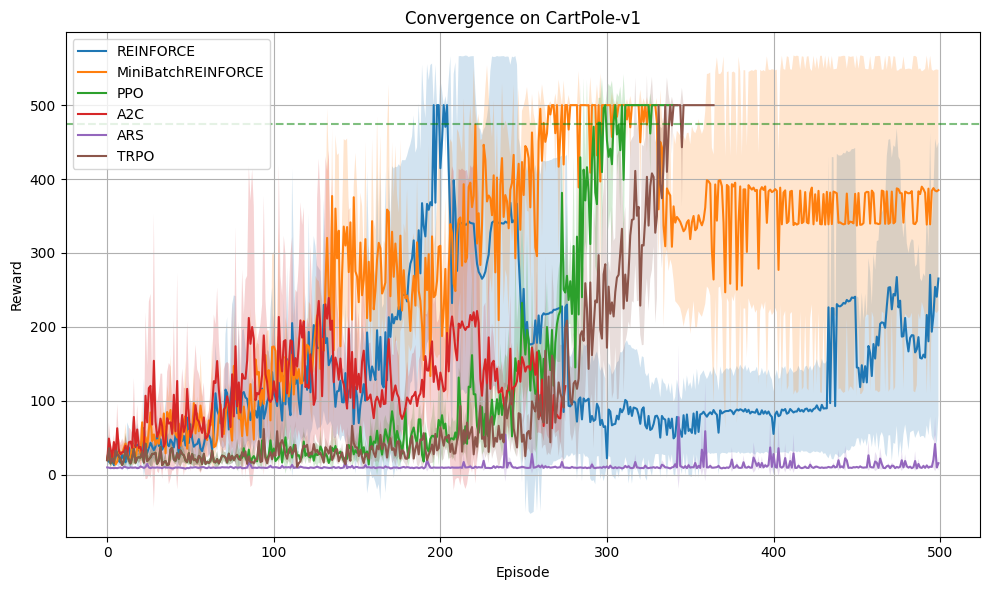

In [8]:
def plot_smoothed_rewards(data, window=10):
    plt.figure(figsize=(10, 6))
    for algo, runs in data.items():
        runs = [r[:max_episodes] for r in runs]
        rewards = list(zip(*runs))
        means = [np.mean(x) for x in rewards]
        stds = [np.std(x) for x in rewards]

        episodes = list(range(len(means)))
        plt.plot(episodes, means, label=algo)
        plt.fill_between(episodes, 
                         [m - s for m, s in zip(means, stds)],
                         [m + s for m, s in zip(means, stds)],
                         alpha=0.2)

    plt.axhline(475, color='green', linestyle='--', alpha=0.5)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"Convergence on {env_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_smoothed_rewards(data)


In [9]:
max_len = min(len(r) for runs in data.values() for r in runs)
truncated_data = {
    algo: [r[:max_len] for r in runs]
    for algo, runs in data.items()
}

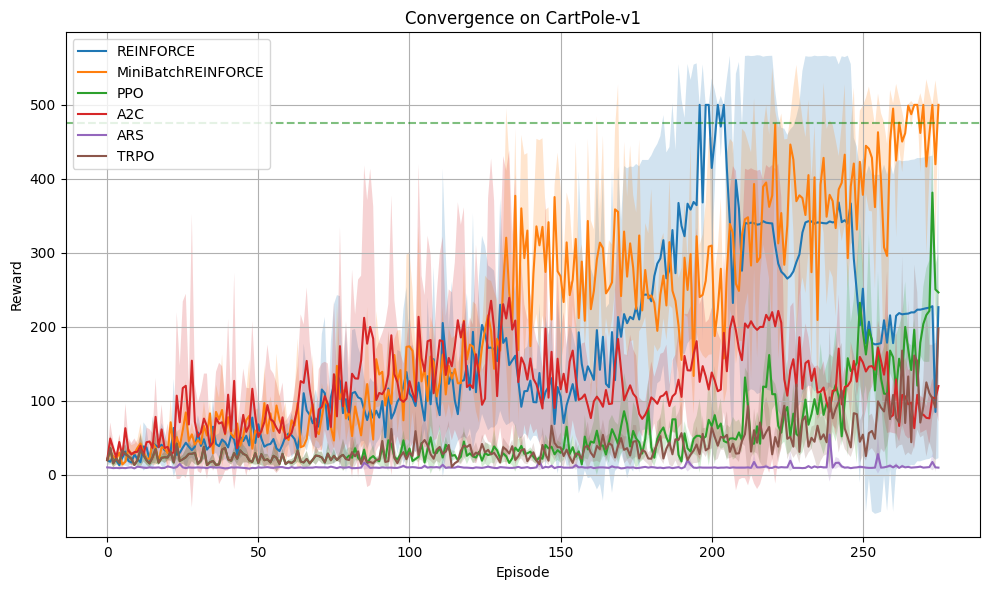

In [10]:
plot_smoothed_rewards(truncated_data)


## Convergence Rate Plot

/Users/bagautdinnukhkadiev/actor-critic-algorithms/venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bagautdinnukhkadiev/actor-critic-algorithms/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


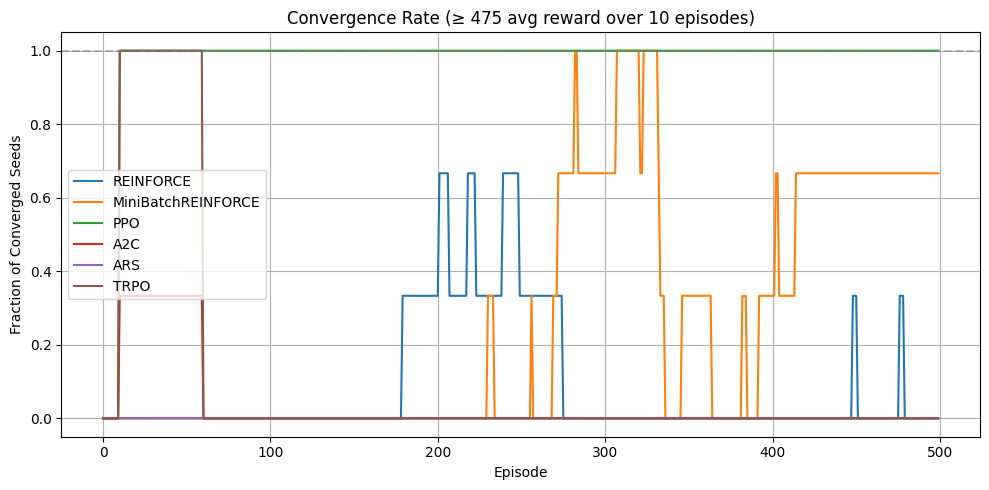

In [15]:
def plot_convergence_rate(data, threshold=475, window=10):
    plt.figure(figsize=(10, 5))
    for algo, runs in data.items():
        runs = [r[:max_episodes] for r in runs]
        num_seeds = len(runs)
        converged_frac = []
        for ep in range(max_episodes):
            count = 0
            for r in runs:
                if ep >= window and np.mean(r[ep - window:ep]) >= threshold:
                    count += 1
            converged_frac.append(count / num_seeds)
        plt.plot(range(max_episodes), converged_frac, label=algo)

    plt.axhline(1.0, linestyle="--", color="gray", alpha=0.5)
    plt.title(f"Convergence Rate (≥ {threshold} avg reward over {window} episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Fraction of Converged Seeds")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_convergence_rate(data)


## Average Convergence Episode per Algorithm

In [16]:
def compute_avg_convergence_episode(data, threshold=475, window=10):
    print("Average convergence episode per algorithm:")
    for algo, runs in data.items():
        conv_episodes = []
        for r in runs:
            r = r[:max_episodes]
            for ep in range(window, len(r)):
                if np.mean(r[ep - window:ep]) >= threshold:
                    conv_episodes.append(ep)
                    break
        if conv_episodes:
            avg_ep = np.mean(conv_episodes)
            print(f"  {algo}: {avg_ep:.1f} (based on {len(conv_episodes)}/{len(runs)} seeds)")
        else:
            print(f"  {algo}: Did not converge in any run.")

compute_avg_convergence_episode(data)


Average convergence episode per algorithm:
  REINFORCE: 199.3 (based on 3/3 seeds)
  MiniBatchREINFORCE: 256.3 (based on 3/3 seeds)
  PPO: 10.0 (based on 3/3 seeds)
  A2C: 10.0 (based on 1/3 seeds)
  ARS: Did not converge in any run.
  TRPO: 10.0 (based on 3/3 seeds)


## Probability of Convergence at Fixed Budgets

In [5]:
def convergence_probability_at_budget(data, threshold=475, window=10, budgets=[100, 200, 300, 400, 500]):
    print("Probability of convergence at fixed episode budgets:")
    for algo, runs in data.items():
        print(f"\n{algo}:")
        for B in budgets:
            count = 0
            for r in runs:
                for ep in range(window, min(len(r), B)):
                    if np.mean(r[ep - window:ep]) >= threshold:
                        count += 1
                        break
            frac = count / len(runs)
            print(f"  Up to episode {B}: {frac*100:.1f}% converged")

convergence_probability_at_budget(data)


Probability of convergence at fixed episode budgets:

REINFORCE:
  Up to episode 100: 0.0% converged
  Up to episode 200: 33.3% converged
  Up to episode 300: 100.0% converged
  Up to episode 400: 100.0% converged
  Up to episode 500: 100.0% converged

MiniBatchREINFORCE:
  Up to episode 100: 0.0% converged
  Up to episode 200: 0.0% converged
  Up to episode 300: 100.0% converged
  Up to episode 400: 100.0% converged
  Up to episode 500: 100.0% converged

PPO:
  Up to episode 100: 100.0% converged
  Up to episode 200: 100.0% converged
  Up to episode 300: 100.0% converged
  Up to episode 400: 100.0% converged
  Up to episode 500: 100.0% converged


## Rliable Metrics (IQM and Confidence Intervals)

In [12]:
from rliable import library as rly
from rliable import metrics

# Format: algo -> list of np.array (each array = last 10 rewards of a seed)
rliable_data = {
    algo: [np.array(run[-10:]) for run in runs]
    for algo, runs in data.items()
}

# Compute IQM and 95% CI
aggregate_scores, score_cis = rly.get_interval_estimates(
    rliable_data,
    metrics.aggregate_iqm,  # <- this goes as a positional argument
    reps=500
)

# Plot
rly.plot_iqm(aggregate_scores, score_cis)


TypeError: aggregate_iqm() takes 1 positional argument but 3 were given